In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from astropy.io import ascii, fits
from astropy.table import Table
import lmfit
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import pandas as pd
import scipy as sp
from scipy.stats import norm
from scipy import stats
from ipywidgets import FloatProgress
from IPython.display import display
from joblib import Parallel, delayed
from MUSE_Models import PNextractor
%config InlineBackend.figure_format = 'retina'


/local/tspriggs/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
hdulist = fits.open("FCC167_data/FCC167_OIII_line_center.fits")
hdr = hdulist[0].header
raw_data = hdulist[0].data
y_data = hdr["NAXIS2"]
x_data = hdr["NAXIS1"]
wavelength = np.exp(hdr['CRVAL3']+np.arange(hdr["NAXIS3"])*hdr['CDELT3'])
# swap axes to y,x,wavelength
list_of_raw_data = np.array(raw_data).reshape(len(wavelength),x_data*y_data)
list_of_raw_data = np.swapaxes(list_of_raw_data, 1, 0)
# Check for nan values
#list_of_raw_data[np.isnan(list_of_raw_data)]=0.0001
# retrieve x and y data shape lengths

#raw_data_shape = raw_data.reshape(y_data,x_data, len(full_wavelength))

Flux_data_shape = list_of_raw_data.reshape(y_data, x_data, len(wavelength))

In [5]:
A_rN = np.load("exported_data/FCC167/A_rN_cen.npy")
gauss_A = np.load("exported_data/FCC167/gauss_A_cen.npy")
Gauss_F = np.load("exported_data/FCC167/gauss_F_cen.npy")

gauss_A_shape = gauss_A.reshape(y_data, x_data)
A_rN_shape = A_rN.reshape(y_data,x_data)
Gauss_F_shape = Gauss_F.reshape(y_data, x_data)

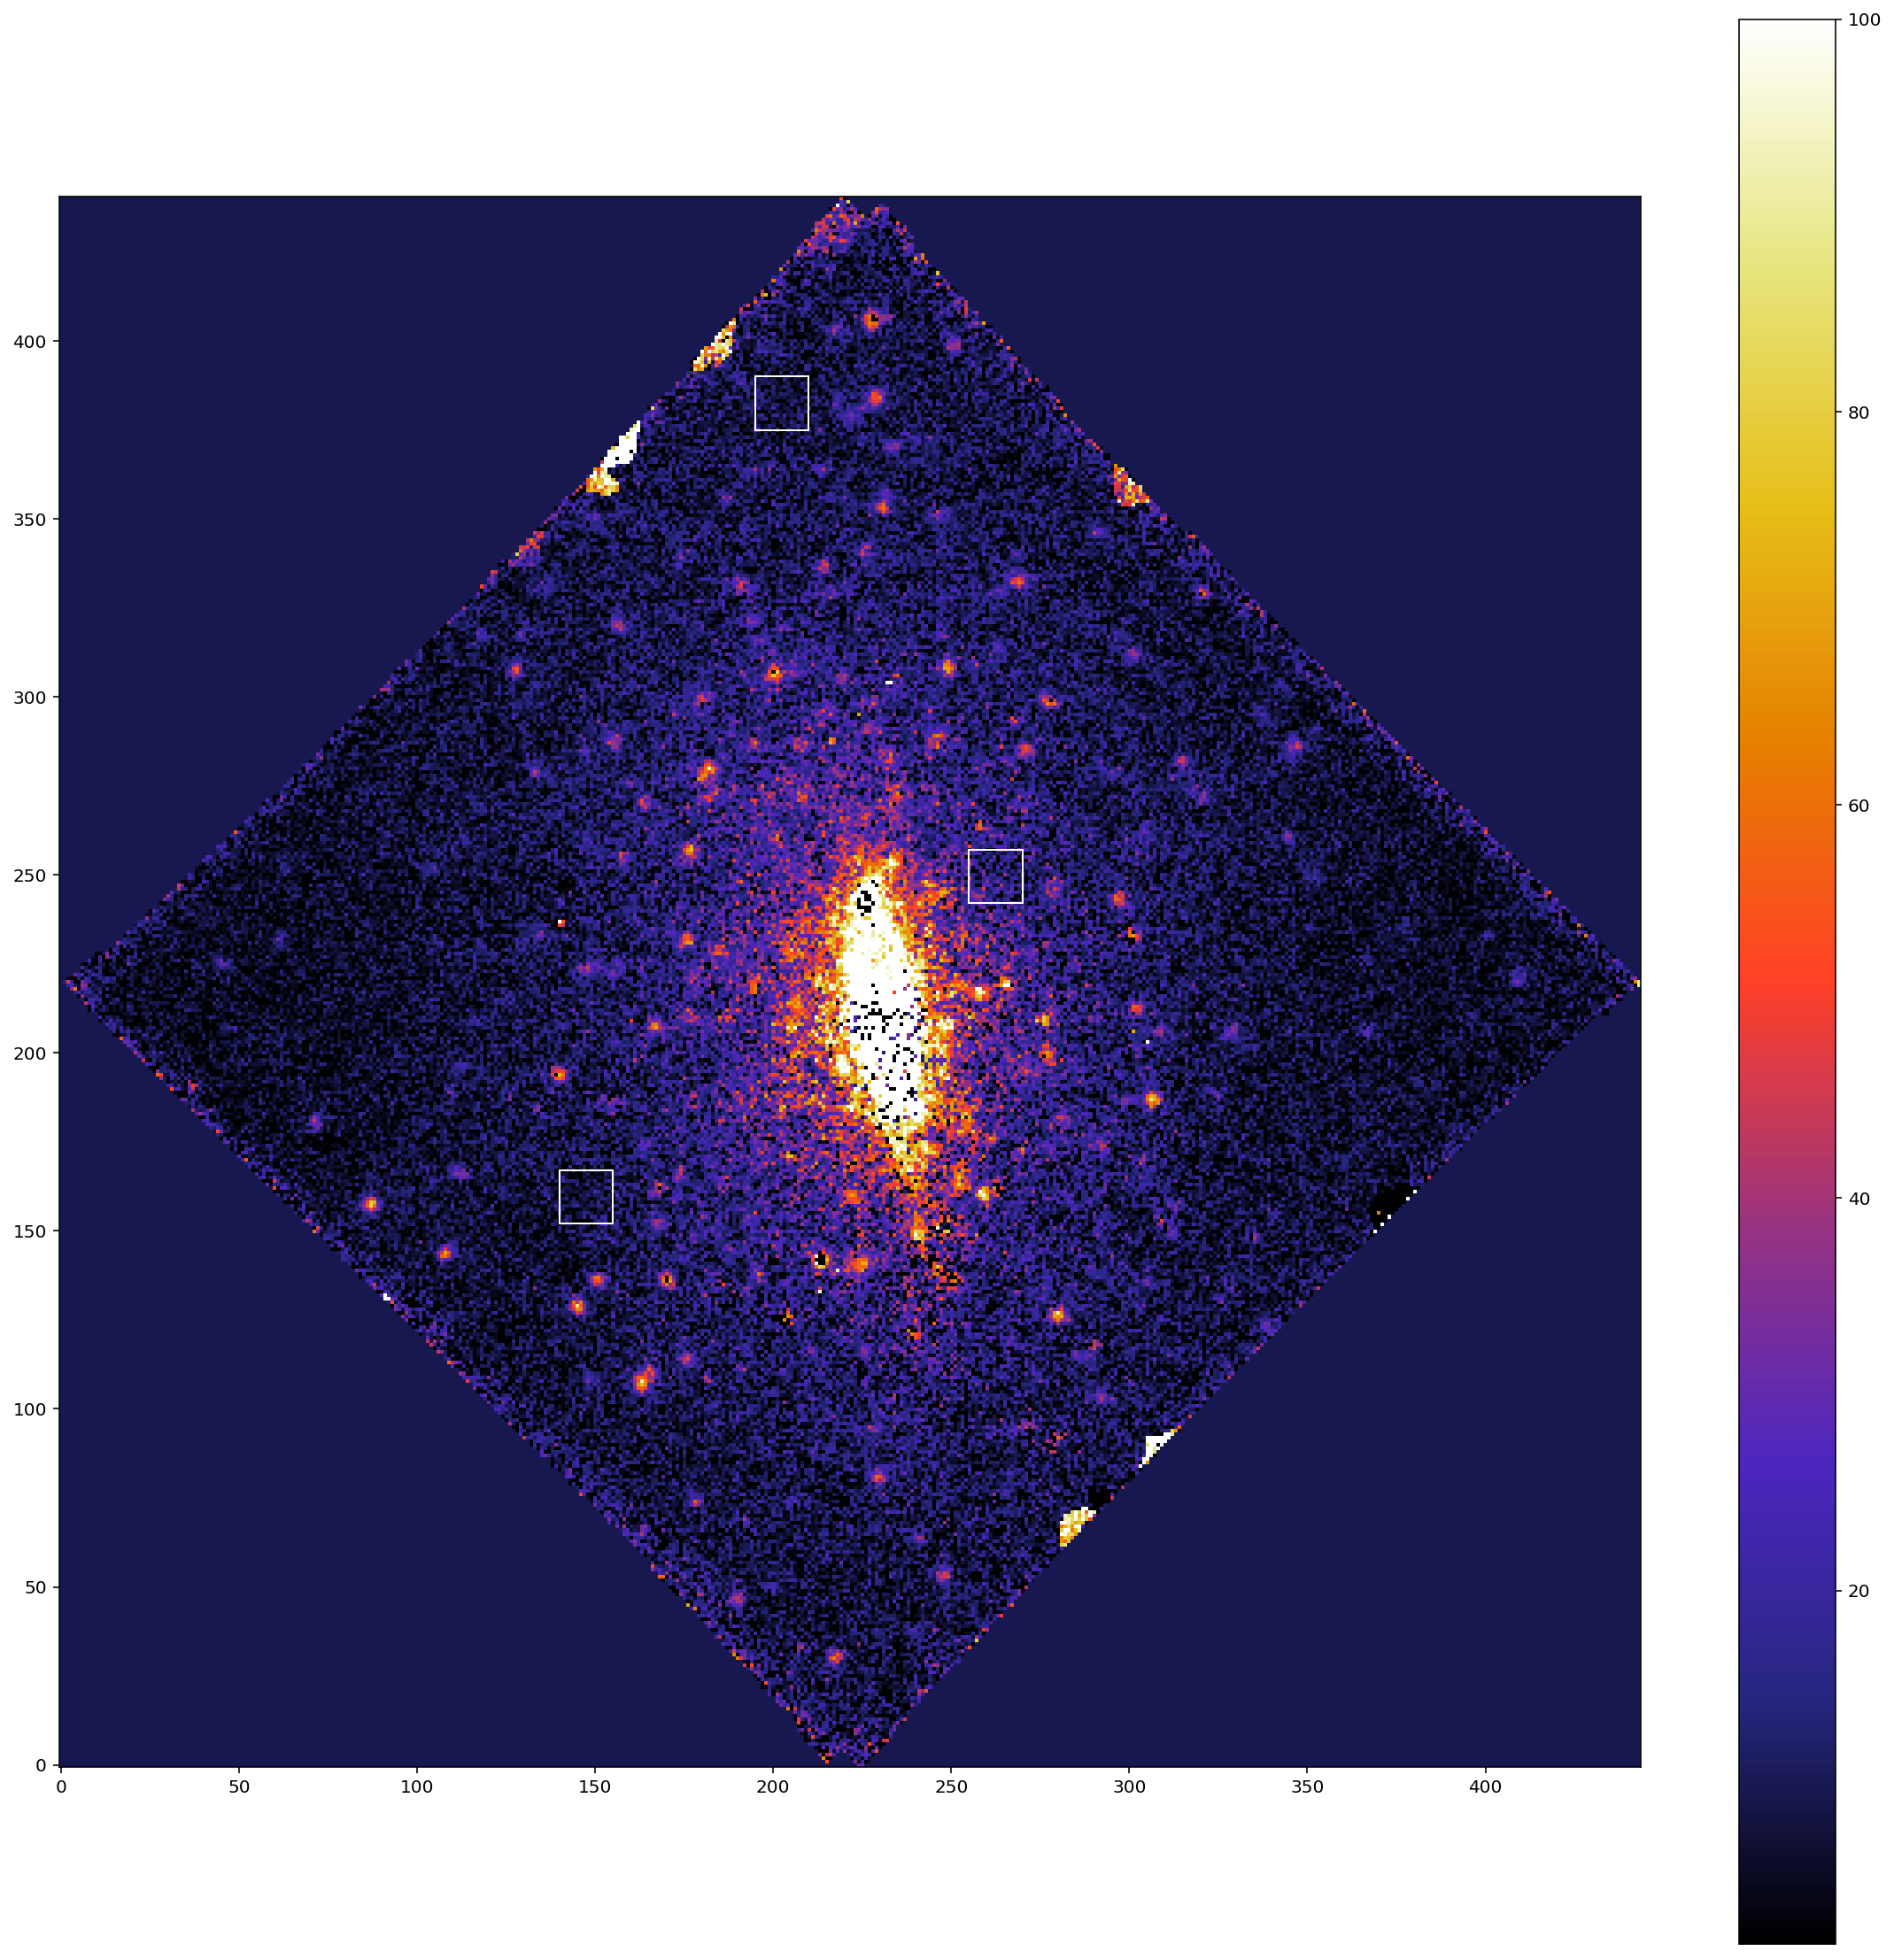

In [53]:
plt.figure(figsize=(20,20))
plt.imshow(gauss_A_shape, origin="lower", cmap="CMRmap", vmin=2, vmax=100)
plt.colorbar()
ax = plt.gca()
ax.add_patch(Rectangle((195, 375), 15, 15, fill=False, edgecolor="white"))
ax.add_patch(Rectangle((140, 152), 15, 15, fill=False, edgecolor="white"))
ax.add_patch(Rectangle((255, 242), 15, 15, fill=False, edgecolor="white"))
plt.draw()

# Normality testing

/local/tspriggs/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


0.03225900934221596
7.580100445799955


AndersonResult(statistic=0.27586515853944604, critical_values=array([0.555, 0.632, 0.758, 0.884, 1.051]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Ks_2sampResult(statistic=0.006964490263459355, pvalue=0.6636281530636877)

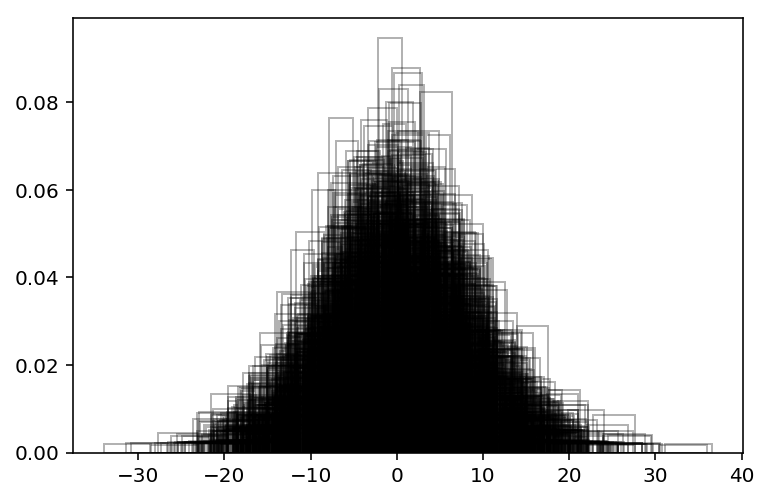

In [56]:
n_pixels=15

noise_regions = [np.array(PNextractor(195, 375, n_pixels, Flux_data_shape, wavelength, dim=2)),
                 np.array(PNextractor(140, 152, n_pixels, Flux_data_shape, wavelength, dim=2)),
                 np.array(PNextractor(255, 242, n_pixels, Flux_data_shape, wavelength, dim=2)),]

reg = 0

mu_list = np.zeros(len(noise_regions[reg]))
std_list = np.zeros(len(noise_regions[reg]))

plt.figure()
for i, spec in enumerate(noise_regions[reg]):
    plt.hist(spec, alpha=0.3,fill=False, normed=True)
    # Fit a normal distribution to the data:
    mu_list[i], std_list[i] = norm.fit(spec)
    
print(np.median(mu_list))
print(np.median(std_list))

display(stats.anderson(np.sum(noise_regions[reg],0), dist="norm"))

gauss_noise = np.random.normal(np.median(mu_list), np.median(std_list), (n_pixels * n_pixels, len(wavelength)))
gauss_noise_r = gauss_noise.reshape(n_pixels*n_pixels*len(wavelength))
noise_test_r = noise_regions[reg].reshape(n_pixels*n_pixels*len(wavelength))

display(stats.ks_2samp(noise_test_r,gauss_noise_r ))

In [3]:
# M_5007
Abs_M_list = np.arange(-5.0, -2.0, 0.05)
dM = 5. * np.log10(21.8) + 25
# m_5007
app_m_list = Abs_M_list + dM
# F_5007, total
total_flux_list = 10.**((app_m_list + 13.74) / -2.5)
flux = total_flux_list / 1e-20

n_pixels = 15
# make moffat profiles that equate to each total flux value
coordinates = [(n,m) for n in range(n_pixels) for m in range(n_pixels)]

x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

def moffat(amplitude, x_0, y_0, FWHM, beta):
    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((x_fit - x_0)**2. + (y_fit - y_0)**2.) / gamma**2.
    return amplitude * (1. + rr_gg)**(-beta)

def gaussian(x, amplitude, mean, stddev, bkg, grad):
    return (bkg + grad*x) + (np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.))) + (np.abs(amplitude)/3.) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / (stddev**2.))

n_PNe = len(Abs_M_list)
n_sim = 20
print("Number of PNe:", n_PNe)
print("Number of Simulations:", n_sim)
print("Total number of simulations to run:", n_PNe * n_sim)

init_FWHM = 3.8
init_beta = 2.0
#find starting amplitude
sum_init = np.sum(moffat(1., n_pixels/2., n_pixels/2., init_FWHM, init_beta))
input_moff_A = flux / sum_init

# Make moffat models = F_5007 (x,y)
Moffat_models = np.array([moffat(moff_A, n_pixels/2, n_pixels/2, init_FWHM, init_beta) for moff_A in input_moff_A])

# A_5007 (x,y)
Amp_x_y = ((Moffat_models) / (np.sqrt(2.*np.pi) * 1.19))


#for i in np.arange(0, n_sim):
#noise_cube = np.array(extractor(295, 50, n_pixels, Flux_data_shape, wavelength))


Number of PNe: 60
Number of Simulations: 20
Total number of simulations to run: 1200


In [328]:
def gen_noise():
    noise = np.random.normal(0.04523, 7.6383, len(wavelength))
    return noise

# store n_sim versions of each PNe at each Abs Mag
gauss_models = np.zeros((n_PNe,n_sim,n_pixels**2,len(wavelength)))
d=10
for i in np.arange(0, n_PNe):
    for j in np.arange(0, n_sim):
        gauss_models[i,j] = np.array([gaussian(wavelength, amp, wavelength[65], 1.19, 0.0, 0.0)+ gen_noise() for amp in Amp_x_y[i]]) 
        
#construct error cube
error_cube = np.zeros((n_PNe, n_sim, n_pixels**2, len(wavelength)))

for PNe_num in np.arange(0, n_PNe):
    for sim_num in np.arange(0, n_sim):
        list_of_std = [np.abs(np.std(spec)) for spec in gauss_models[PNe_num, sim_num]]
        error_cube[PNe_num, sim_num] = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0,len(list_of_std))]


In [234]:
np.save("exported_data/sim_input_fluxes", total_flux_list)

In [330]:
# Fit 3D

list_of_A_OIII = np.zeros((n_PNe,n_sim))
list_of_resids = np.zeros((n_PNe,n_sim))
list_of_total_fitted_flux = np.zeros((n_PNe,n_sim))
list_of_fitted_flux = np.zeros((n_PNe, n_sim, n_pixels**2))

def residual(params, x, data, error, PNe_number, run):
    # List of parameters
    moffat_amp = params['moffat_amp']
    x_0 = params['x_0']
    y_0 = params['y_0']
    FWHM = params['FWHM']
    beta = params["beta"]
    mean = params["mean"]
    Gauss_std = params["Gauss_std"]
    Gauss_bkg = params["Gauss_bkg"]
    Gauss_grad = params["Gauss_grad"]
    #Moffat model
    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((x_fit - x_0)**2. + (y_fit - y_0)**2.) / gamma**2.
    F_OIII_xy = moffat_amp * (1. + rr_gg)**(-beta)  
    # Convert Moffat flux to amplitude
    A_OIII_xy = ((F_OIII_xy) / (np.sqrt(2*np.pi) * 1.19)) 
    
    #Construct model gaussian profiles for each amplitude value in cube
    model_spectra = [(Gauss_bkg + (Gauss_grad * x) + Amp * np.exp(- 0.5 * (x - mean)** 2 / Gauss_std**2.) +
             (Amp/3.) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / Gauss_std**2.)) for Amp in A_OIII_xy]
    
    # Store things
    list_of_fitted_flux[PNe_num, run] = F_OIII_xy
    list_of_total_fitted_flux[PNe_num, run] = np.sum(F_OIII_xy) * 1e-20
    list_of_resids[PNe_num, run] = np.std(data - model_spectra)
    list_of_A_OIII[PNe_num, run] = np.max(A_OIII_xy)
    
    return (data - model_spectra)**2 #/ error**2


params = Parameters()
params.add('moffat_amp', value=50., min=0.01)
params.add('x_0', value=n_pixels/2., min=0.01, max=n_pixels)
params.add('y_0', value=n_pixels/2, min=0.01, max=n_pixels)
params.add('FWHM', value=4.0, min=0.01, max=14.0, vary=True) #4.47)
params.add("beta", value=2.5, min=0.01, max=14.0, vary=True)#, vary=False) #2.39)
params.add("mean", value=5030., min=5000, max=5060)
params.add("Gauss_std", value=1.19, vary=False)
params.add("Gauss_bkg", value=0.001)
params.add("Gauss_grad", value=0.001)

list_of_M_amp = np.zeros((n_PNe,n_sim))
list_of_FWHM = np.zeros((n_PNe,n_sim))
list_of_beta = np.zeros((n_PNe,n_sim))

#f = FloatProgress(min=0, max=n_PNe*n_sim, description="Fitting progress", )
#display(f)
for PNe_num in np.arange(0, n_PNe):
    for sim_num in np.arange(0, n_sim):
        # Run the minimizer
        result = minimize(residual, params, args=(wavelength, gauss_models[PNe_num, sim_num], error_cube[PNe_num, sim_num], PNe_num, sim_num))
        list_of_M_amp[PNe_num, sim_num] = result.params["moffat_amp"]
        list_of_FWHM[PNe_num, sim_num] = result.params["FWHM"]
        list_of_beta[PNe_num, sim_num] = result.params["beta"]
#        f.value+=1.



In [4]:
#A / rN
#A_by_rN = list_of_A_OIII / list_of_resids
##
###save outputs
#np.save("exported_data/input_moff_A", input_moff_A)
#np.save("exported_data/output_moff_A", list_of_M_amp)
#np.save("exported_data/output_FWHM", list_of_FWHM)
#np.save("exported_data/output_beta", list_of_beta)
#np.save("exported_data/A_by_rN", A_by_rN)
#np.save("exported_data/total_F", list_of_total_fitted_flux)
#
# read in saved files
input_moff_A = np.load("exported_data/input_moff_A.npy")
list_of_M_amp = np.load("exported_data/output_moff_A.npy")
list_of_FWHM = np.load("exported_data/output_FWHM.npy")
list_of_beta = np.load("exported_data/output_beta.npy")
A_by_rN = np.load("exported_data/A_by_rN.npy")
list_of_total_fitted_flux = np.load("exported_data/total_F.npy")

In [334]:
len(A_by_rN[0])

20

In [5]:
# Calculate Deltas

m_5007_out = -2.5 * np.log10(list_of_total_fitted_flux) - 13.74

M_5007_out = m_5007_out - dM

n_PNe = len(A_by_rN)
n_sim = len(A_by_rN[0])

# create plots and delta params, out minus in
delta_moff_amp = np.zeros((n_PNe,n_sim))
for pne in np.arange(0, n_PNe):
    for sim in np.arange(0, n_sim):
        delta_moff_amp[pne, sim] = 100 * ((input_moff_A[pne] - list_of_M_amp[pne, sim])/input_moff_A[pne])

delta_total_F = np.zeros((n_PNe,n_sim))
for pne in np.arange(0, n_PNe):
    for sim in np.arange(0, n_sim):
        delta_total_F[pne, sim] = 100 * (flux[pne] - (list_of_total_fitted_flux[pne, sim]/1e-20))/flux[pne]
        
delta_M_5007 = np.zeros((n_PNe,n_sim))
for pne in np.arange(0, n_PNe):
    for sim in np.arange(0, n_sim):
        delta_M_5007[pne, sim] = 100 * (Abs_M_list[pne] - M_5007_out[pne, sim]) / Abs_M_list[pne]

delta_FWHM = 100 * (init_FWHM - list_of_FWHM) / init_FWHM
#delta_beta = 100 * (init_beta - list_of_beta) / init_beta
delta_beta = init_beta - list_of_beta


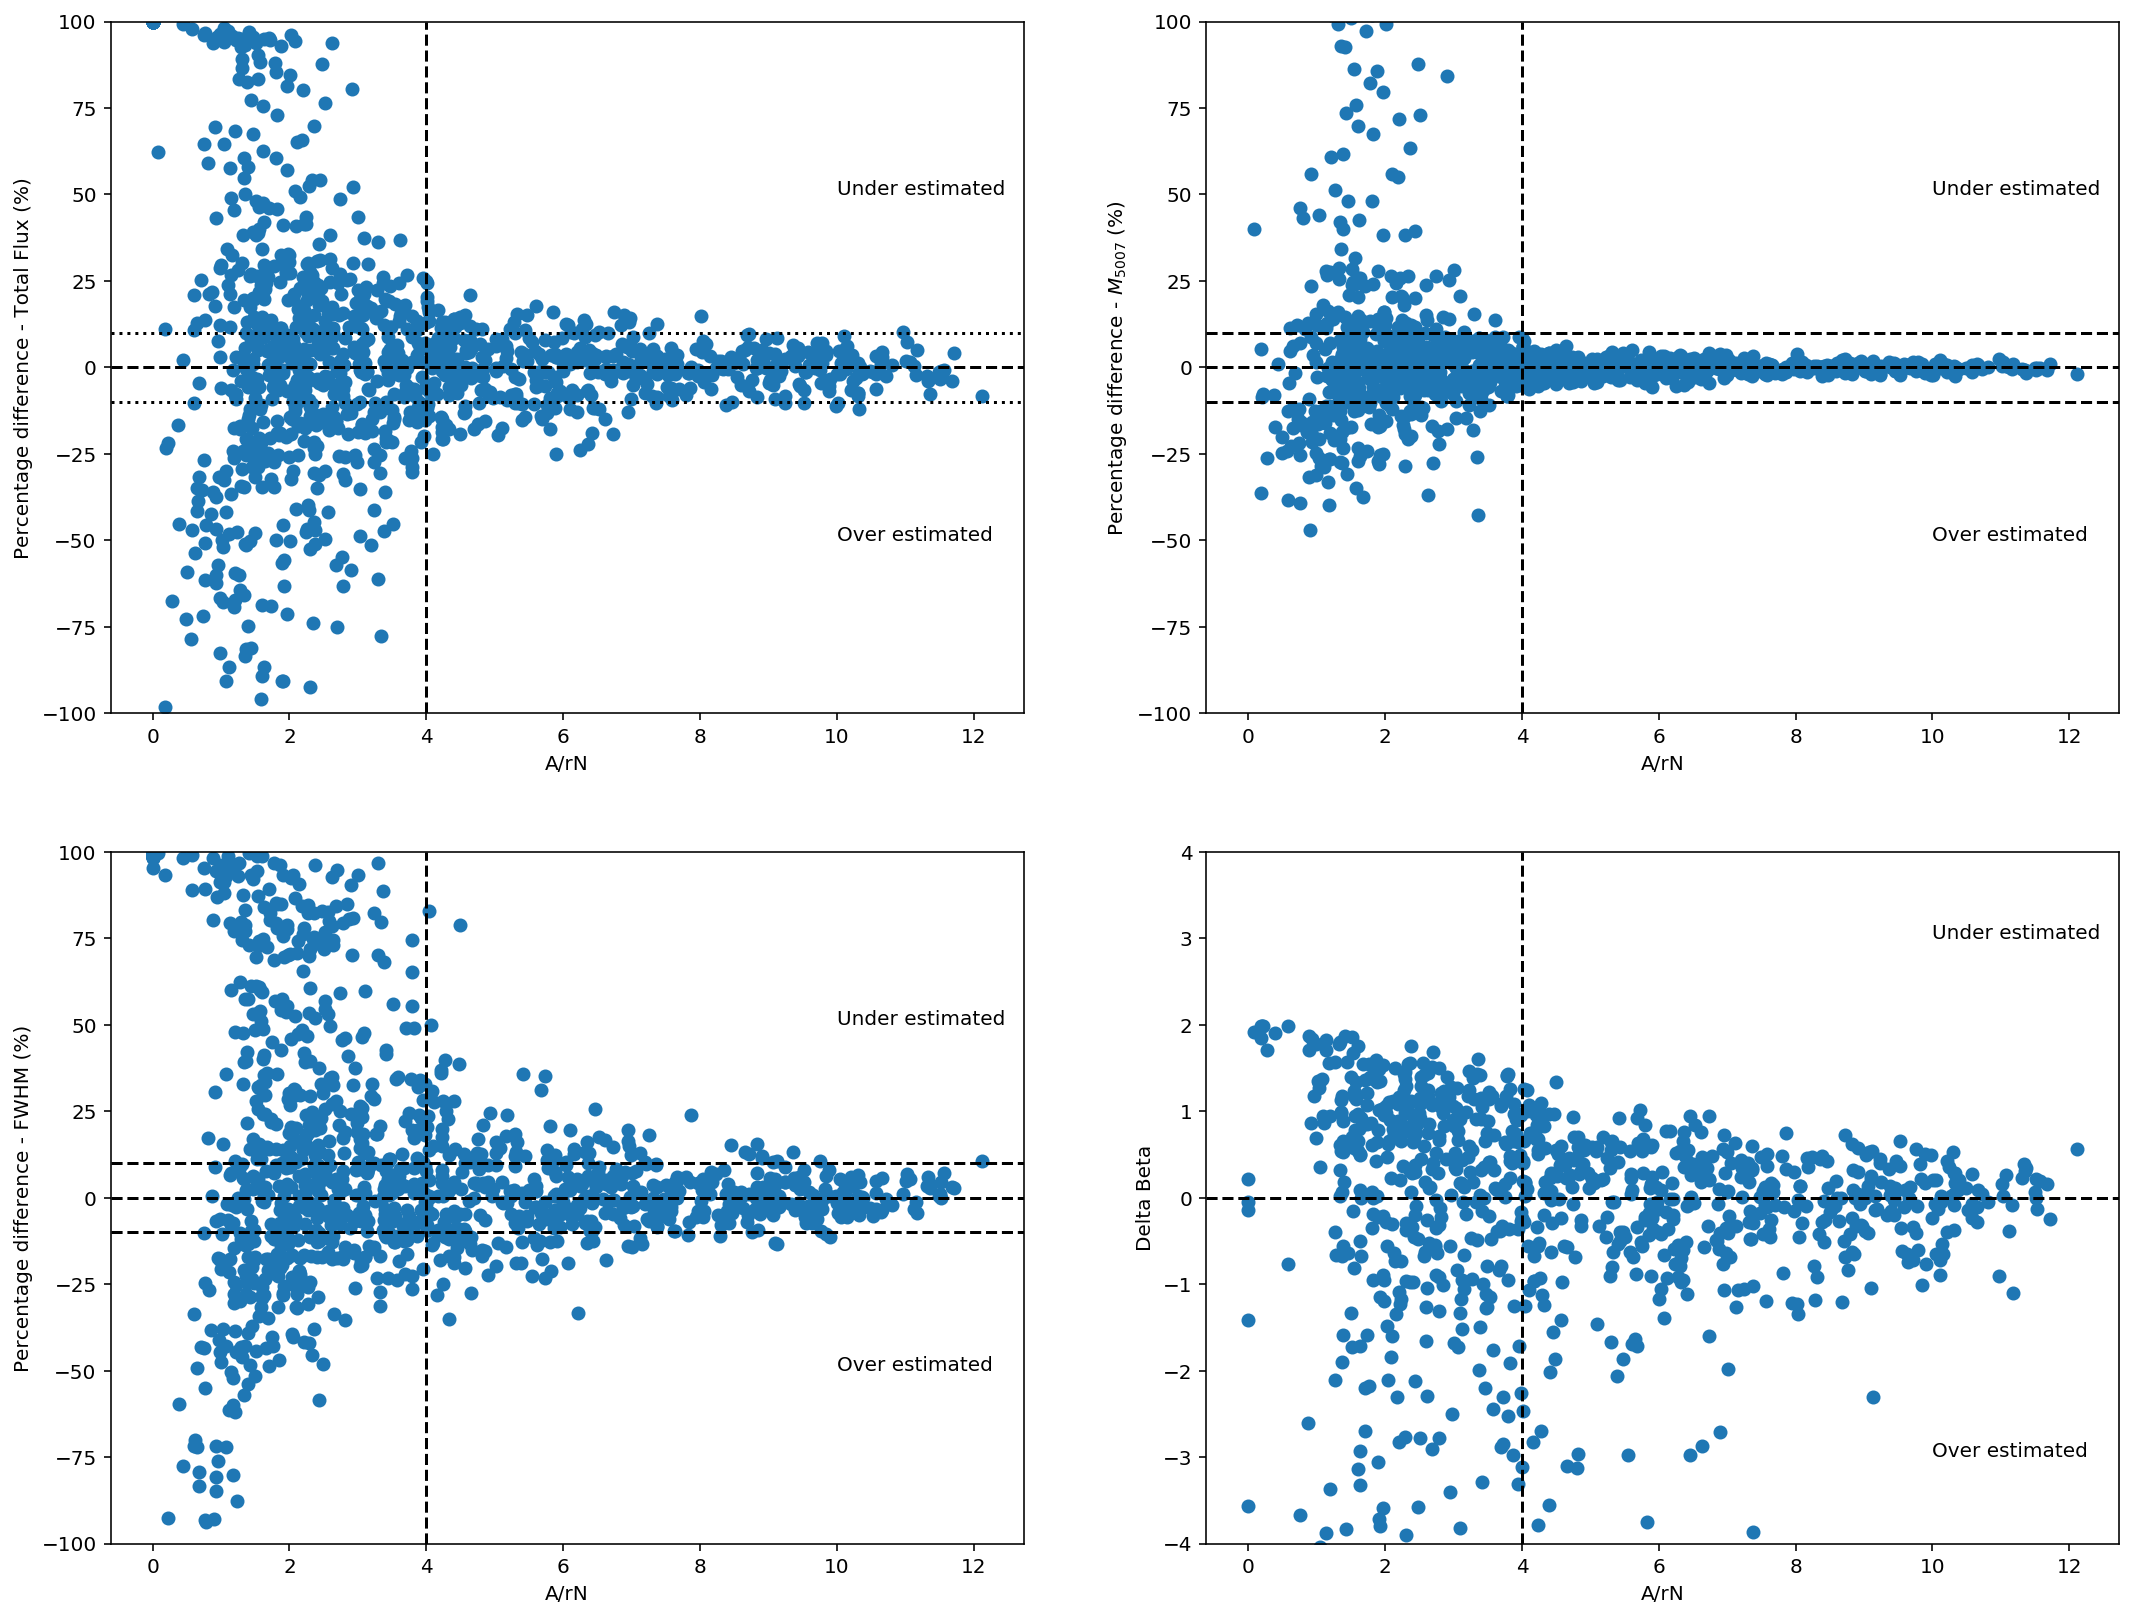

In [14]:
plt.figure(1, figsize=(18,14))

ax0 = plt.subplot(2,2,1)
plt.scatter(A_by_rN, delta_total_F)
plt.xlabel("A/rN")
plt.ylabel("Percentage difference - Total Flux (%)")
plt.axhline(y=0, c="k", ls="dashed")
plt.axvline(x=4, c="k", ls="dashed")
ax0.annotate("Under estimated", xy=(1,1), xytext=(10,50))
ax0.annotate("Over estimated", xy=(1,1), xytext=(10,-50))
plt.axhline(y=10, c="k", ls="dotted")
plt.axhline(y=-10, c="k", ls="dotted")
plt.ylim(-100,100)

ax1 = plt.subplot(2,2,2)
plt.scatter(A_by_rN, delta_M_5007)
plt.xlabel("A/rN")
plt.ylabel("Percentage difference - $M_{5007}$ (%)")
plt.axhline(y=0, c="k", ls="dashed")
plt.axvline(x=4, c="k", ls="dashed")
plt.axhline(10, c="k", ls="dashed")
plt.axhline(-10, c="k", ls="dashed")
ax1.annotate("Under estimated", xy=(1,1), xytext=(10,50))
ax1.annotate("Over estimated", xy=(1,1), xytext=(10,-50))
plt.ylim(-100,100)

ax2 = plt.subplot(2,2,3)
plt.scatter(A_by_rN, delta_FWHM)
plt.xlabel("A/rN")
plt.ylabel("Percentage difference - FWHM (%)")
plt.axhline(y=0, c="k", ls="dashed")
plt.axvline(x=4, c="k", ls="dashed")
plt.axhline(10, c="k", ls="dashed")
plt.axhline(-10,c="k", ls="dashed")
ax2.annotate("Under estimated", xy=(1,1), xytext=(10,50))
ax2.annotate("Over estimated", xy=(1,1), xytext=(10,-50))
plt.ylim(-100,100)

ax3 = plt.subplot(2,2,4)
plt.scatter(A_by_rN, delta_beta)
plt.xlabel("A/rN")
plt.ylabel("Delta Beta")
plt.axhline(y=0, c="k", ls="dashed")
plt.axvline(x=4, c="k", ls="dashed")
ax3.annotate("Under estimated", xy=(1,1), xytext=(10,3))
ax3.annotate("Over estimated", xy=(1,1), xytext=(10,-3))
plt.ylim(-4,4)

plt.savefig("Plots/simulations/PSF_sim_updated.png")

Text(0,0.5,'FWHM')

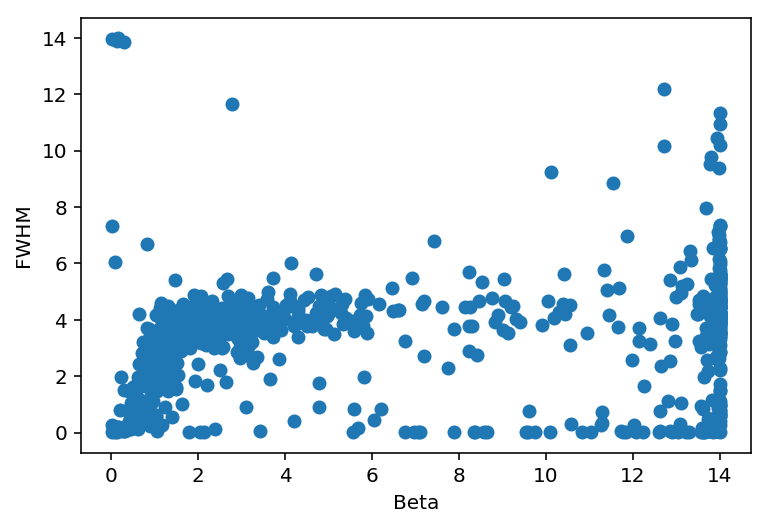

In [344]:
plt.scatter(list_of_beta, list_of_FWHM)
plt.xlabel("Beta")
plt.ylabel("FWHM")

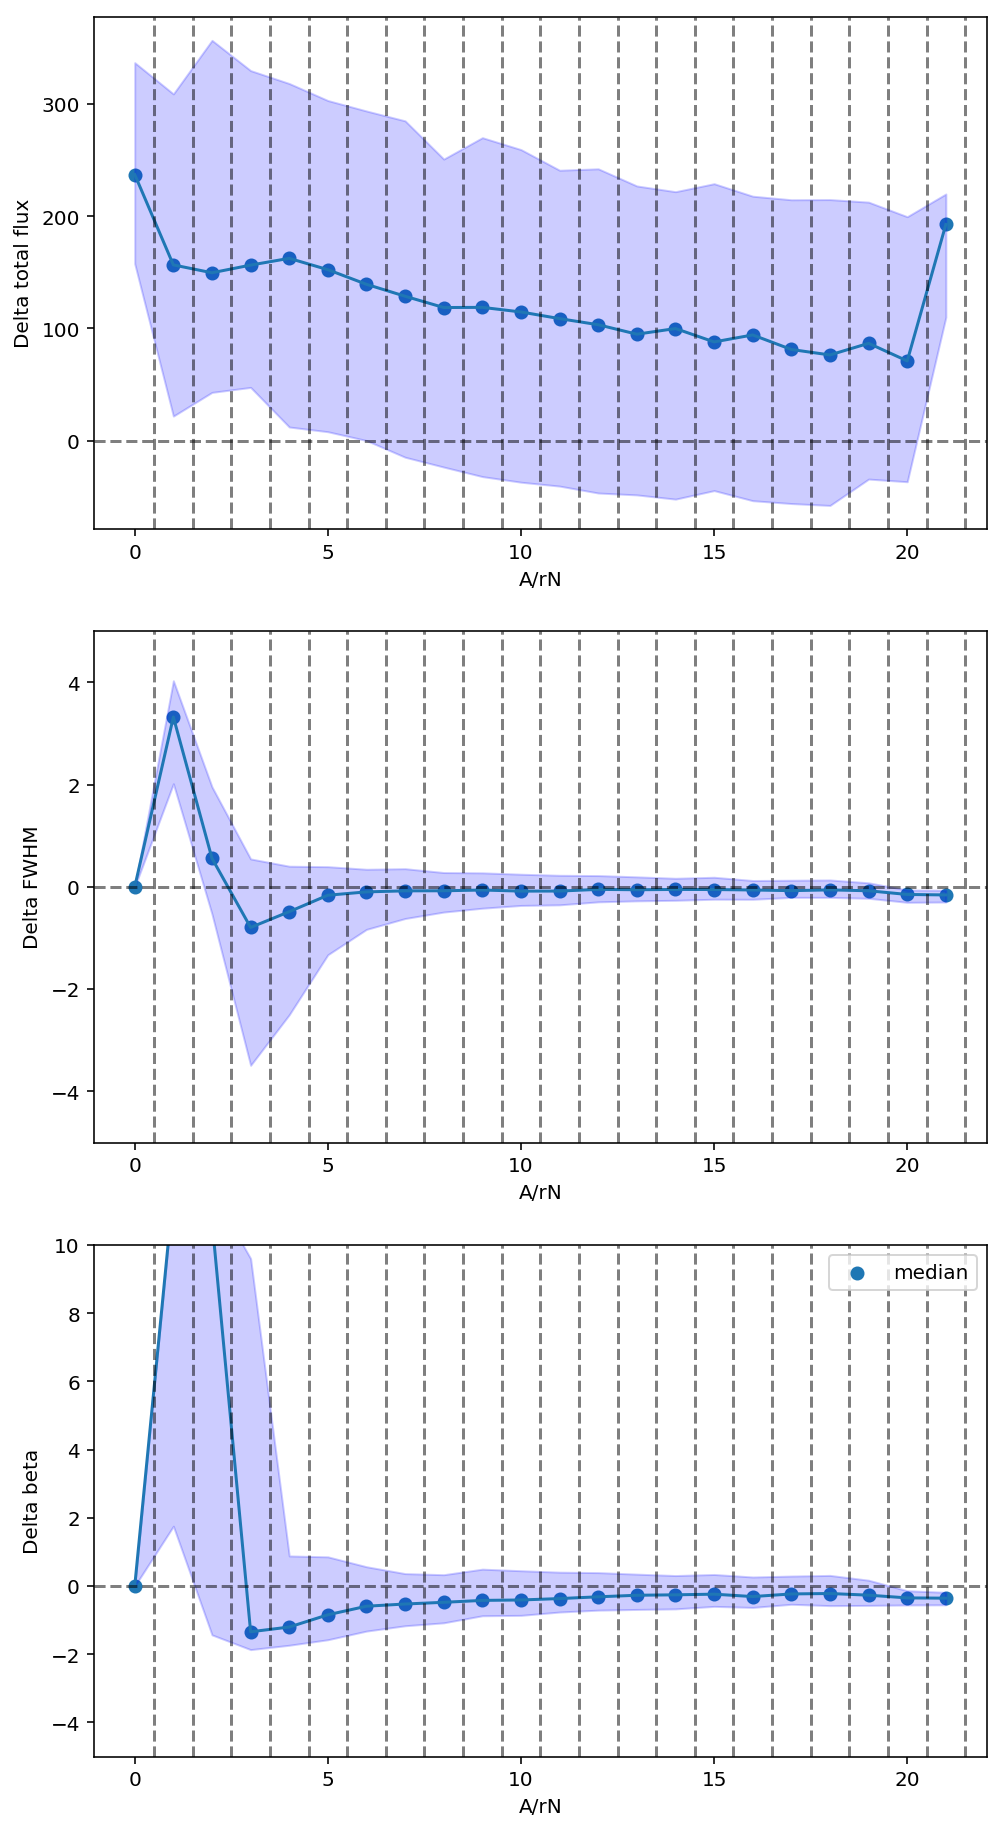

In [99]:
# median for flux
binned_flux = np.zeros(int(round(np.max(A_by_rN))))
binned_16th_percentile_flux = np.zeros(int(round(np.max(A_by_rN))))
binned_84th_percentile_flux = np.zeros(int(round(np.max(A_by_rN))))

low = 0
high = 1
for i in np.arange(0,len(binned_flux)):
    bin_index = np.where(np.logical_and(low <= A_by_rN, A_by_rN < high))
    if len(delta_total_F[bin_index]) > 0:
        binned_flux[i] = np.percentile(delta_total_F[bin_index], 50)
        binned_16th_percentile_flux[i] = np.percentile(delta_total_F[bin_index], 16)
        binned_84th_percentile_flux[i] = np.percentile(delta_total_F[bin_index], 84)
        low += 1.
        high += 1.
    else:
        continue

plt.figure(2, figsize=(8,16))

plt.subplot(3,1,1)
plt.scatter(np.arange(0,float(len(binned_flux))), binned_flux, label="median")
plt.plot(np.arange(0,float(len(binned_flux))), binned_flux)
plt.fill_between(np.arange(0,float(len(binned_flux))),binned_16th_percentile_flux, binned_84th_percentile_flux, color="blue", alpha=0.2, linestyle="None")
plt.axhline(y=0, c="k", ls="dashed", alpha=0.5)
for j in np.arange(0.5,int(len(binned_flux)+0.5)):
    plt.axvline(x=j,c="k",  ls="dashed", alpha=0.5)
plt.xlabel("A/rN")
plt.ylabel("Delta total flux")

# median for gamma
binned_FWHM = np.zeros(int(round(np.max(A_by_rN))))
binned_16th_percentile_FWHM = np.zeros(int(round(np.max(A_by_rN))))
binned_84th_percentile_FWHM = np.zeros(int(round(np.max(A_by_rN))))

low = 0
high = 1
for i in np.arange(1,len(binned_FWHM)):
    bin_index = np.where(np.logical_and(low <= A_by_rN, A_by_rN < high))
    if len(delta_FWHM[bin_index]) > 0:
        binned_FWHM[i] = np.percentile(delta_FWHM[bin_index], 50)
        binned_16th_percentile_FWHM[i] = np.percentile(delta_FWHM[bin_index], 16)
        binned_84th_percentile_FWHM[i] = np.percentile(delta_FWHM[bin_index], 84)
        low += 1.
        high += 1.
    else:
        continue
    
plt.subplot(3,1,2)
plt.scatter(np.arange(0,float(len(binned_FWHM))), binned_FWHM, label="median")
plt.plot(np.arange(0,float(len(binned_FWHM))), binned_FWHM)
plt.fill_between(np.arange(0,float(len(binned_FWHM))), binned_16th_percentile_FWHM, binned_84th_percentile_FWHM, color="blue", alpha=0.2, linestyle="None")
plt.axhline(y=0, c="k", ls="dashed", alpha=0.5)
for j in np.arange(0.5,int(len(binned_FWHM)+0.5)):
    plt.axvline(x=j,c="k",  ls="dashed", alpha=0.5)
plt.xlabel("A/rN")
plt.ylabel("Delta FWHM")
plt.ylim(-5,5)
    
# median for alpha
binned_beta = np.zeros(int(round(np.max(A_by_rN))))
binned_16th_percentile_beta = np.zeros(int(round(np.max(A_by_rN))))
binned_84th_percentile_beta = np.zeros(int(round(np.max(A_by_rN))))

low = 0
high = 1
for i in np.arange(1,len(binned_beta)):
    bin_index = np.where(np.logical_and(low <= A_by_rN, A_by_rN < high))
    if len(delta_beta[bin_index]) > 0:
        binned_beta[i] = np.percentile(delta_beta[bin_index], 50)
        binned_16th_percentile_beta[i] = np.percentile(delta_beta[bin_index], 16)
        binned_84th_percentile_beta[i] = np.percentile(delta_beta[bin_index], 84)
        low += 1.
        high += 1.
    else:
        continue

plt.subplot(3,1,3)
plt.scatter(np.arange(0,float(len(binned_beta))), binned_beta, label="median")
plt.plot(np.arange(0,float(len(binned_beta))), binned_beta)
plt.fill_between(np.arange(0,float(len(binned_beta))),binned_16th_percentile_beta, binned_84th_percentile_beta, color="blue", alpha=0.2, linestyle="None")
plt.axhline(y=0, c="k", ls="dashed", alpha=0.5)
for j in np.arange(0.5,int(len(binned_beta)+0.5)):
    plt.axvline(x=j,c="k",  ls="dashed", alpha=0.5)
plt.xlabel("A/rN")
plt.ylabel("Delta beta")
plt.ylim(-5,10)
plt.legend(loc=1)

plt.savefig("Plots/Median_results.png_free_params_run_v3_vertical.png")

In [103]:
A_by_rN[28:48,0]

array([ 10.19556128,  10.01297707,   9.83268711,   9.65504499,
         9.47795176,   9.30720243,   9.14086771,   8.97644672,
         8.81423754,   8.65834129,   8.50014214,   8.34739082,
         8.19953206,   8.05170478,   7.90698111,   7.76616089,
         7.63386762,   7.50443029,   7.37399866,   7.24543172])

In [106]:
first_PNe_A_rN = A_by_rN[32:52,0]
first_PNe_g_list = gauss_models[32:52,0]
first_PNe_err_cube = error_cube[32:52,0]

sim_df = pd.DataFrame()
sim_df["A/rN"] = first_PNe_A_rN


def PSF_residuals(PSF_params, l, x_2D, y_2D, data, err):
    FWHM = PSF_params['FWHM']
    beta = PSF_params["beta"]
    Gauss_std = PSF_params["Gauss_std"]
    
    def generate_model(x, y, moffat_amp, FWHM, beta, Gauss_std, Gauss_bkg, Gauss_grad, mean):
        gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
        rr_gg = ((np.array(x_2D) - x)**2 + (np.array(y_2D) - y)**2) / gamma**2
        F_OIII_xy = moffat_amp * (1 + rr_gg)**(-beta)
        
        A_OIII_xy = ((F_OIII_xy) / (np.sqrt(2*np.pi) * Gauss_std))
        
        model_spectra = [(Gauss_bkg + (Gauss_grad * l) + np.abs(Amp) * np.exp(- 0.5 * (l - mean)** 2 / Gauss_std**2.) +
             (np.abs(Amp)/2.98) * np.exp(- 0.5 * (l - (mean - 47.9399))** 2 / Gauss_std**2.)) for Amp in A_OIII_xy]
        
        return model_spectra
    
    list_of_models = {}
    for k in np.arange(0, len(data)):
        list_of_models["model_%d" %k] = generate_model(PSF_params["x_%d" %k], PSF_params["y_%d" %k], PSF_params["moffat_amp_%d" %k], FWHM, beta, Gauss_std, PSF_params["gauss_grad_%d" %k], PSF_params["gauss_bkg_%d" %k], PSF_params["mean_%d" %k])
   
    resid = {}
    for m in np.arange(0, len(data)):
        resid["resid_%d" %m] = (data[m] - list_of_models["model_%d" %m]) / err[m]
    
    if len(resid) > 1.:
        return np.concatenate([resid[x] for x in sorted(resid)],1)
    else:
        return resid["resid_0"]

num_psf=20
psf_fitted_FWHM = np.zeros(num_psf)
psf_fitted_beta = np.zeros(num_psf)
psf_A_rN_total = np.zeros(num_psf)

#params = Parameters()
def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_%d" %n, value=amp, min=0.0001)
    PSF_params.add("x_%d" %n, value=n_pixels/2., min=0.000001, max=n_pixels)
    PSF_params.add("y_%d" %n, value=n_pixels/2., min=0.000001, max=n_pixels)
    PSF_params.add("mean_%d" %n, value=mean, min=4970., max=5070.)
    PSF_params.add("gauss_bkg_%d" %n, value=0.1, min=-100., max=300.)
    PSF_params.add("gauss_grad_%d" %n, value=0.001, min=-2., max=2.)


#params.add('FWHM', value=4.0, min=0.001, max=12., vary=True)
#params.add("beta", value=4.0, min=0.001, max=12., vary=True) 
#params.add("Gauss_std", value=1.19, vary=False) # LSF, instrumental resolution.
    
for j in np.arange(0, num_psf):
    sel_PNe = sim_df.nlargest(j+1, "A/rN").index.values
    selected_PNe = first_PNe_g_list[sel_PNe]
    selected_PNe_err = first_PNe_err_cube[sel_PNe]
    PSF_params = Parameters()
    for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=200.0, mean=5005.0)
    PSF_params.add('FWHM', value=3.0, min=0.001, max=12., vary=True)
    PSF_params.add("beta", value=3.0, min=0.001, max=12., vary=True) 
    PSF_params.add("Gauss_std", value=1.16, vary=False)
    psf_A_rN_total[j] = np.sqrt(np.sum(sim_df.iloc[sel_PNe]["A/rN"]**2))
    results = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err), nan_policy="propagate")
    psf_fitted_FWHM[j] = results.params["FWHM"].value
    psf_fitted_beta[j] = results.params["beta"].value



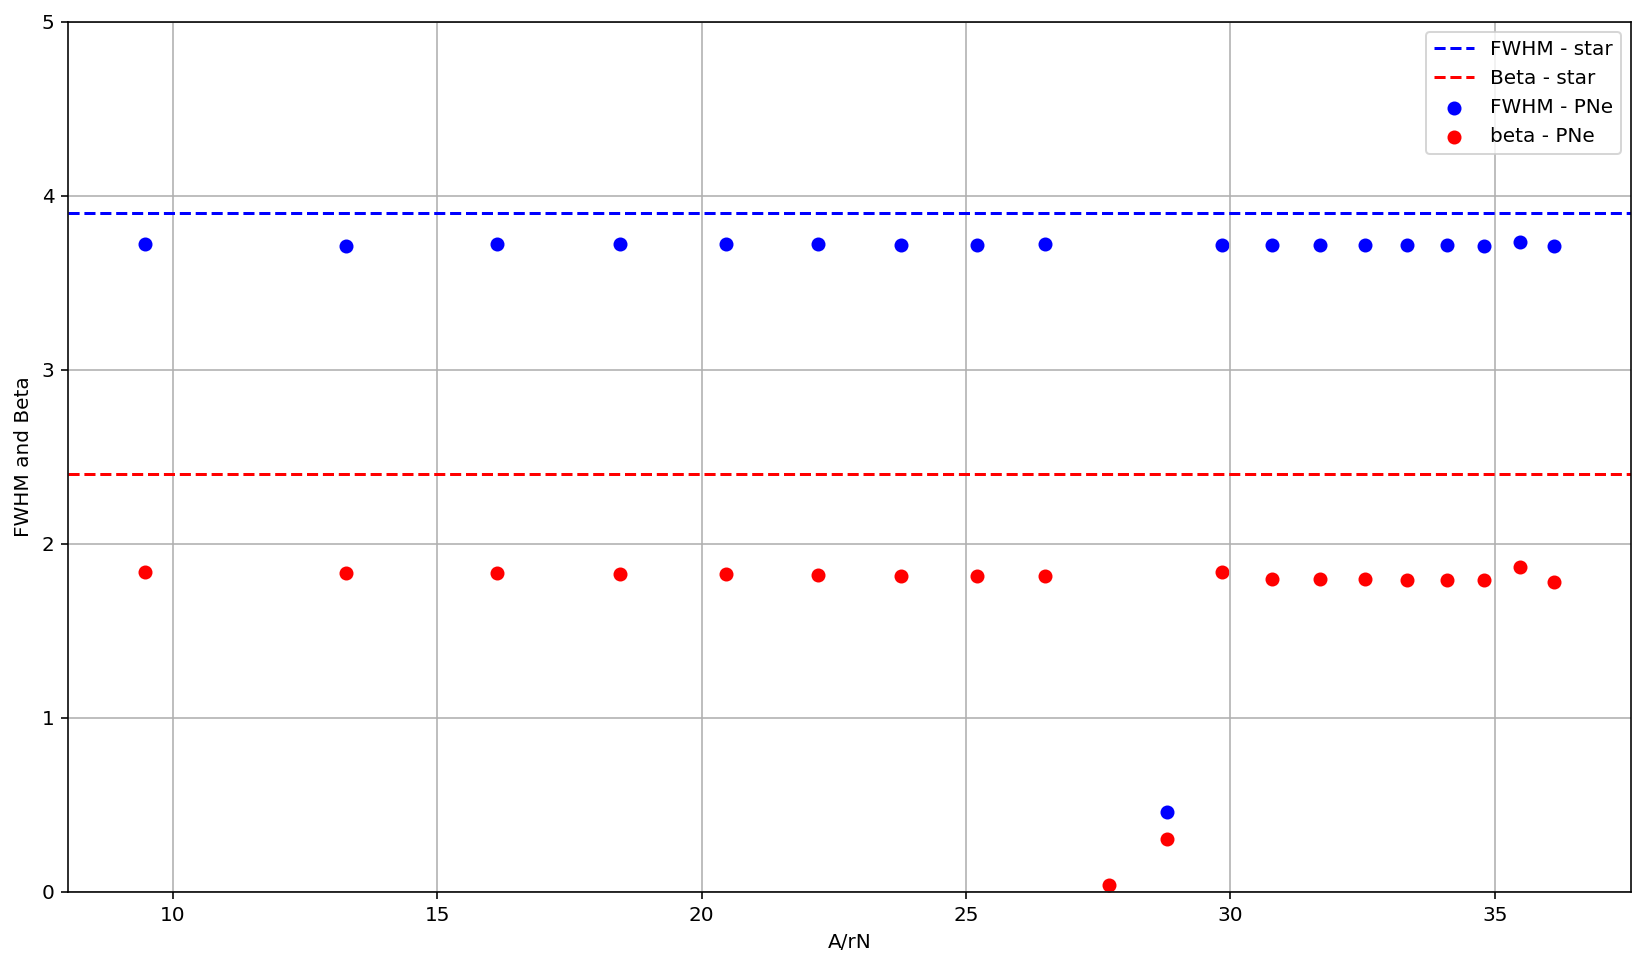

In [107]:
plt.figure(figsize=(14,8))
plt.scatter(psf_A_rN_total, psf_fitted_FWHM, label="FWHM - PNe", c="blue")
plt.scatter(psf_A_rN_total, psf_fitted_beta, label="beta - PNe", c="red")
plt.xlabel("A/rN")
plt.ylabel("FWHM and Beta")
plt.grid()
#plt.xlim(0,36)
plt.ylim(0,5.)

plt.axhline(init_FWHM, label="FWHM - star", ls="dashed", c="blue")
plt.axhline(init_beta, label="Beta - star", ls="dashed", c="red")
plt.legend()
#plt.savefig("Plots/FCC170/PSF_A_rN_FWHM_beta_with_star_halo.png")